# Dynamical Systems: Simulation and Analysis

In this notebook we take a look at dynamical systems by the example of
a pendulum. We implement the system, compute solution trajectories and
analyze the fixed points in the system's phase space.

So let's get started. First, we need some imports.

In [2]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as sint

from src.utils.plotting import init_plot_style

# initialize our global plot style
init_plot_style()

Below we implement the dynamical system, i.e., we specify how to compute
the systems flow and its Jacobian. Moreover, we compute solution trajectories
by using a numerical ODE solver.

In [3]:
class Pendulum:
    """
    Implements the dynamical system description of a pendulum.
    """

    def __init__(self, alpha=1, beta=0.2):
        """
        Parameters
        ----------
        alpha : float
            Friction parameter.
        beta : float
            Geometry parameter.
        """
        self.alpha = alpha
        self.beta = beta

    def flow(self, z: np.ndarray, t=None):
        """ Flow of a nonlinear dynamical system.

        Parameters
        ----------
        z : numpy.ndarray
            State vector or batch of state vectors.
        t : numpy.ndarray
            Time. Not used in this system.

        Returns
        ------
        numpy.ndarray
            The flow evaluated at state(s) z.
        """
        assert z.shape[0] == 2
        z = z.reshape(2, -1)
        xdot = z[1, :]
        ydot = -self.beta * np.sin(z[0, :]) - self.alpha * z[1, :]
        zdot = np.stack((xdot, ydot), axis=0)
        return zdot if zdot.shape[1] > 1 else zdot.squeeze(1)

    def jacobian(self, z: np.ndarray):
        """ Jacobian of the dynamical system.

        Parameters
        ----------
        z : numpy.ndarray
            State vector.

        Returns
        ------
         numpy.ndarray
            The Jacobian evaluated at z.
        """
        z = z.reshape(-1, )
        assert len(z) == 2
        jacobian = np.array([[0., -self.beta * np.cos(z[0])], [1., -self.alpha]])
        return jacobian

    def compute_trajectory(self, z: np.ndarray, t_max: float, Ts: float):
        """ Computes the system trajectory for a given initial state..

        Parameters
        ----------
        z : numpy.ndarray
            Initial state vector.
        t_max : float
            Maximum trajectory length in seconds.
        Ts : float
            Evaluation step size in seconds.

        Returns
        ------
         numpy.ndarray, numpy.ndarray
            The trajectory (sequence of state vectors) and a time vector.
        """
        time_steps = int(t_max / Ts)
        t = np.linspace(0., t_max, time_steps)
        return sint.odeint(self.flow, z, t).T, t


We can now instantiate our system with the desired parameters and
look a an example trajectory, i.e., the evolution of the system's state
for a given initial state as a function of time.

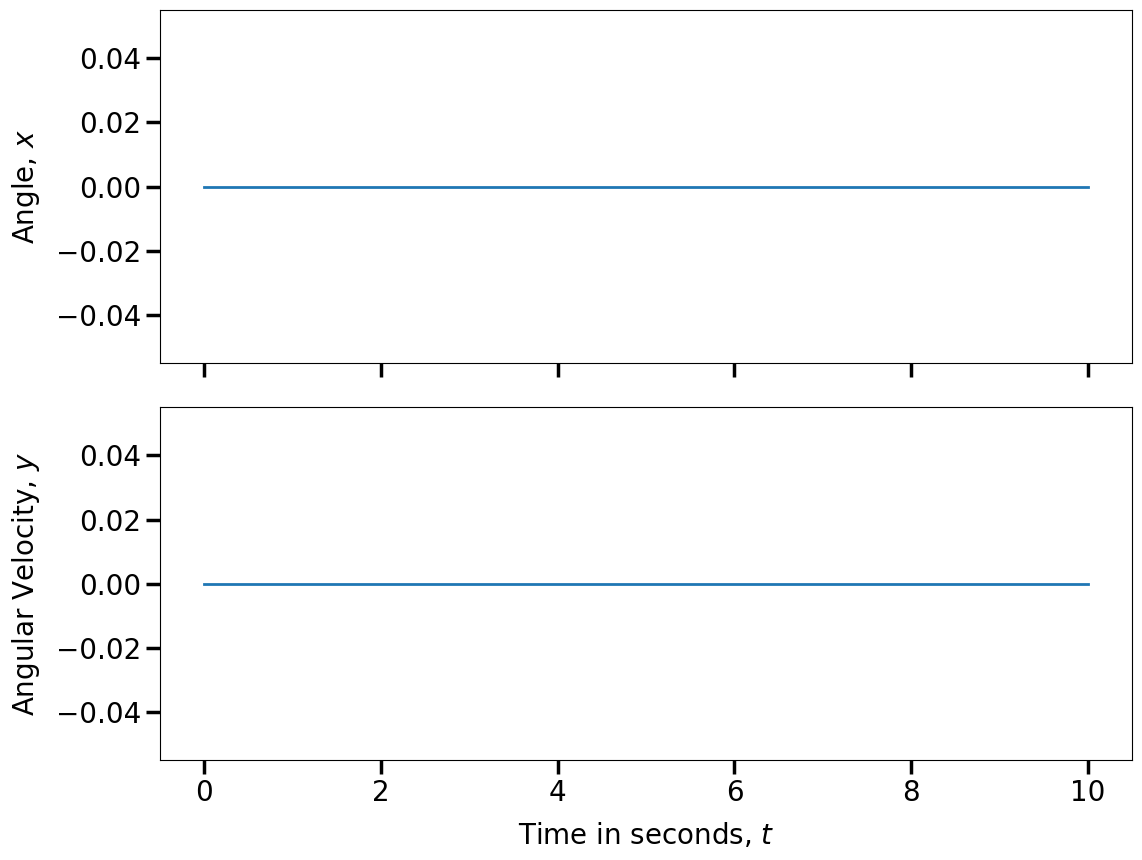

In [4]:
# create pendulum
pendulum = Pendulum(alpha=1., beta=5.)

# define initial state and compute trajectory
z0 = np.array([0, 0])
# z0 = np.array([np.pi / 2, 0])
# z0 = np.array([0, 2.])
trajectory, time = pendulum.compute_trajectory(z0, t_max=10, Ts=1e-2)

# plot trajectory as a function of time
fig, ax = plt.subplots(2, 1, sharex=True)
plt.xlabel('Time in seconds, $t$')
ax[0].plot(time, trajectory[0, :])
ax[0].set_ylabel('Angle, $x$')
ax[1].plot(time, trajectory[1, :])
ax[1].set_ylabel('Angular Velocity, $y$')
plt.tight_layout()

More informative than a single trajectory is the phase space of the system.
Here, we generate and plot a vector field in the phase space representing the
system's flow. Note that the length of the vectors are all equal for a better
visualization and they do not reflect their true length. Instead, we encode the
vector magnitudes with colors.

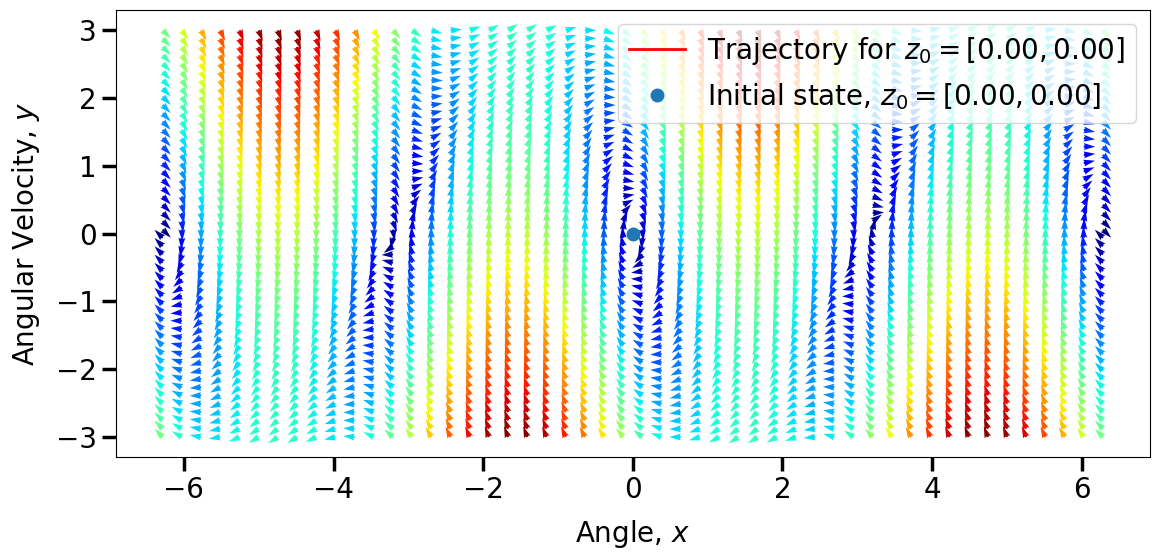

In [5]:
# generate a point grid over the phase space
x = np.linspace(-2. * np.pi, 2. * np.pi, 50)
y = np.linspace(-3, 3, 50)
X, Y = np.meshgrid(x, y)
Z = np.stack((X, Y), axis=2).reshape((-1, 2)).T

# compute the flow for the grid points
F = pendulum.flow(Z)

# plot phase space with example trajectory
plt.figure(figsize=(12,6))
cscale = np.linalg.norm(F, axis=0)
plt.quiver(Z[0, :], Z[1, :], F[0, :] / cscale, F[1, :] / cscale, cscale, cmap=plt.get_cmap('jet'))
plt.plot(trajectory[0, :], trajectory[1, :], 'r', label=f'Trajectory for $z_0 = [{z0[0]:.2f}, {z0[0]:.2f}]$')
plt.plot(z0[0], z0[1], 'o', label=f'Initial state, $z_0 = [{z0[0]:.2f}, {z0[0]:.2f}]$')
plt.xlabel('Angle, $x$')
plt.ylabel('Angular Velocity, $y$')
plt.legend()
plt.tight_layout()


Finally, we can numerically verify our analytical stability analysis
by computing the Eigenvalues of the system's Jacobian evaluated at the
fixed points.

In [6]:
# define fixed point of interest
z_fp = np.array([0, 0])
# z_fp = np.array([np.pi, 0])

# compute eigenvalues
jacobian = pendulum.jacobian(z_fp)
evs = np.linalg.eigvals(jacobian)
print(f'First Eigenvalue is {evs[0]:.2f}')
print(f'Second Eigenvalue is {evs[1]:.2f}')


First Eigenvalue is -0.50+2.18j
Second Eigenvalue is -0.50-2.18j
